In [1]:
import tensorflow as tf
%matplotlib inline
%load_ext tensorboard
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import imgaug as ia
from datetime import datetime
from math import cos, sin, pi

In [2]:
ia.seed(42)

In [3]:

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [5]:
x_train.shape

(60000, 28, 28, 1)

In [6]:
H, W,_ = x_train[0].shape

In [51]:
# Pipeline:
# (1) Crop images from each side by 1-16px, do not resize the results
#     images back to the input size. Keep them at the cropped size.
# (2) Horizontally flip 50% of the images.
# (3) Blur images using a gaussian kernel with sigma between 0.0 and 3.0.
seq = iaa.Sequential([
        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
    iaa.OneOf([
    
        iaa.Affine(
            scale={"x": (0.6, 1.1), "y": (0.5, 1.1)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-30, 30),
            shear=(-15, 15),
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            scale={"x": (0.6, 1.1), "y": (0.6, 1.1)},
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            scale={"x": (0.6, 0.8), "y": (0.6, 0.8)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            rotate=(-60, 60),
            #shear=(-30, 30),
            order=[0, 1],
            cval=(0),
        ),
        iaa.Affine(
            shear=(-40, 40),
            order=[0, 1],
            cval=(0),
        ),

    ]
    )
])
x_train_aug = seq(images=x_train)  # done by the library
x_test_aug = seq(images=x_test)  # done by the library


In [52]:
import pickle

In [53]:

distorted_mnist = {"x_train_distorted":x_train_aug, "x_test_distorted": x_test_aug, "y_train":y_train, "y_test":y_test}
pickle.dump(distorted_mnist , open( "distorted_mnist.p", "wb" ) )

In [54]:
import pickle
distorted_mnist = pickle.load( open( "distorted_mnist.p", "rb" ) )
x_train_aug = distorted_mnist["x_train_distorted"]
x_test_aug = distorted_mnist["x_test_distorted"]

In [55]:
baseline_model=tf.keras.models.load_model('mnist_base_line_model')

OSError: SavedModel file does not exist at: mnist_base_line_model/{saved_model.pbtxt|saved_model.pb}

In [ ]:
# the accuracy is low if we directly use the pre-trained model for the distorted dataset
baseline_model.evaluate(x_test_aug, y_test)

In [56]:
from math import ceil
def draw_samples(images, images_per_row=5):
    num = len(images)
    per_row = min(images_per_row, num)
    rows = ceil(num /per_row)
    fig, axs = plt.subplots(rows, per_row)
    count = 0 
    for i in range(rows):
        
        for j in range(images_per_row):
            count+=1
            if (count > num):
                break
            if rows == 1:
                axs[j+i*per_row].imshow(images[j+i*per_row], cmap='gray')
            else:
                axs[i,j].imshow(images[j+i*per_row], cmap='gray')
            
    plt.show()


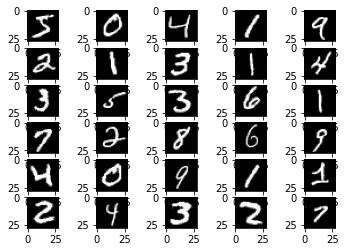

In [134]:
draw_samples(x_train[:30])

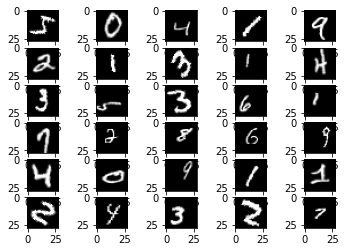

In [135]:
draw_samples(x_train_aug[:30])

In [223]:
model = tf.keras.models.Sequential([
  #tf.keras.layers.MaxPooling2D((2, 2),),
  tf.keras.layers.Conv2D(6, (3,3), input_shape=(H, W,1), padding='valid',activation="relu"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(16, (3,3),padding='valid',activation="relu"),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(120, activation='relu'),
  tf.keras.layers.Dense(84, activation='relu'),
  tf.keras.layers.Dense(10),
    #tf.keras.layers.Softmax()
])

In [128]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])


In [184]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [185]:
# completely retrain the original model with mnist dataset + distorted mnist dataset
model.fit(tf.concat([x_train_aug, x_train],0), tf.concat([y_train, y_train],0), epochs=5)

Epoch 1/5
3750/3750 [==============================] - 20s 5ms/step - loss: 0.6887 - accuracy: 0.7725
Epoch 2/5
3750/3750 [==============================] - 21s 6ms/step - loss: 0.1684 - accuracy: 0.9464
Epoch 3/5
3750/3750 [==============================] - 24s 6ms/step - loss: 0.1194 - accuracy: 0.9616
Epoch 4/5
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0924 - accuracy: 0.9707
Epoch 5/5
3750/3750 [==============================] - 22s 6ms/step - loss: 0.0782 - accuracy: 0.9737


In [186]:
# not good for distorted data
model.evaluate(x_test_aug, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1898 - accuracy: 0.9434


[0.18978169560432434, 0.9434000253677368]

In [187]:
# still good for undistorted original data
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0430 - accuracy: 0.9874


[0.042976558208465576, 0.9873999953269958]

In [188]:
def generate_normalized_homo_meshgrids(inputs):
    # for x, y in grid, -1 <=x,y<=1
    batch_size = tf.shape(inputs)[0]
    _, H, W,_ = inputs.shape
    x_range = tf.range(W)
    y_range = tf.range(H) 
    x_mesh, y_mesh = tf.meshgrid(x_range, y_range)
    x_mesh = (x_mesh/W-0.5)*2
    y_mesh = (y_mesh/H-0.5)*2
    y_mesh = tf.reshape(y_mesh, (*y_mesh.shape,1))
    x_mesh = tf.reshape(x_mesh, (*x_mesh.shape,1))
    ones_mesh = tf.ones_like(x_mesh)
    homogeneous_grid = tf.concat([x_mesh, y_mesh, ones_mesh],-1)
    homogeneous_grid = tf.reshape(homogeneous_grid, (-1, 3,1))
    homogeneous_grid = tf.dtypes.cast(homogeneous_grid, tf.float32)
    homogeneous_grid = tf.expand_dims(homogeneous_grid, 0)
    return tf.tile(homogeneous_grid, [batch_size, 1,1,1])


In [189]:
def transform_grids(transformations, grids, inputs):
    with tf.name_scope("transform_grids"):
        trans_matrices=tf.reshape(transformations, (-1, 2,3))
        batch_size = tf.shape(trans_matrices)[0]
        gs = tf.squeeze(grids, -1)

        reprojected_grids = tf.matmul(trans_matrices, gs, transpose_b=True)
        # transform grid range from [-1,1) to the range of [0,1)
        reprojected_grids = (tf.linalg.matrix_transpose(reprojected_grids) + 1)*0.5
        _, H, W, _ = inputs.shape
        reprojected_grids = tf.math.multiply(reprojected_grids, [W, H])

        return reprojected_grids

In [190]:
def generate_four_neighbors_from_reprojection(inputs, reprojected_grids):
    _, H, W, _ = inputs.shape
    
    x, y = tf.split(reprojected_grids, 2, axis=-1)

    x1 = tf.floor(x)
    x1 = tf.dtypes.cast(x1, tf.int32)

    x2 = x1 + tf.constant(1) 

    y1 = tf.floor(y)
    y1 = tf.dtypes.cast(y1, tf.int32)
    y2 = y1 + tf.constant(1) 
    
    y_max = tf.constant(H - 1, dtype=tf.int32)
    x_max = tf.constant(W - 1, dtype=tf.int32)
    zero = tf.zeros([1], dtype=tf.int32)

    x1_safe = tf.clip_by_value(x1, zero, x_max)
    y1_safe = tf.clip_by_value(y1, zero, y_max)
    x2_safe = tf.clip_by_value(x2, zero, x_max)
    y2_safe = tf.clip_by_value(y2, zero, y_max)
    return x1_safe, y1_safe, x2_safe, y2_safe

In [191]:
def bilinear_sample(inputs, reprojected_grids):
    x1, y1, x2, y2 = generate_four_neighbors_from_reprojection(inputs, reprojected_grids)
    x1y1 = tf.concat([y1,x1],-1)
    x1y2 = tf.concat([y2,x1],-1)
    x2y1 = tf.concat([y1,x2],-1)
    x2y2 = tf.concat([y2,x2],-1)

    pixel_x1y1 = tf.gather_nd(inputs, x1y1, batch_dims=1)
    pixel_x1y2 = tf.gather_nd(inputs, x1y2, batch_dims=1)
    pixel_x2y1 = tf.gather_nd(inputs, x2y1, batch_dims=1)
    pixel_x2y2 = tf.gather_nd(inputs, x2y2, batch_dims=1)
    x, y = tf.split(reprojected_grids, 2, axis=-1)
    wx = tf.concat([tf.dtypes.cast(x2, tf.float32) - x, x -tf.dtypes.cast(x1, tf.float32)],-1)
    wx = tf.expand_dims(wx, -2)
    wy = tf.concat([tf.dtypes.cast(y2, tf.float32) - y, y - tf.dtypes.cast(y1, tf.float32)],-1)
    wy = tf.expand_dims(wy, -1)
    Q = tf.concat([pixel_x1y1, pixel_x1y2, pixel_x2y1, pixel_x2y2], -1)
    Q_shape = tf.shape(Q)
    Q = tf.reshape(Q, (Q_shape[0], Q_shape[1],2,2))
    Q = tf.cast(Q, tf.float32)

    r = wx@Q@wy
    _, H, W, channels = inputs.shape

    r = tf.reshape(r, (-1,H,W,1))
    return r

    
    

In [192]:
inputs = x_train_aug[:3]
transformations = tf.constant([[1,0,0,0,0.3,0.35],[cos(pi/4),-sin(pi/4),0,sin(pi/4),cos(pi/4),0],[1,0,0.1,0,1,0.1]],dtype=tf.float32)
transformations


<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.3       ,
         0.35      ],
       [ 0.70710677, -0.70710677,  0.        ,  0.70710677,  0.70710677,
         0.        ],
       [ 1.        ,  0.        ,  0.1       ,  0.        ,  1.        ,
         0.1       ]], dtype=float32)>

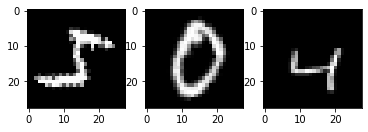

In [193]:
draw_samples(inputs)

In [194]:
grids = generate_normalized_homo_meshgrids(inputs)
#print(grids)
reprojected_grids = transform_grids(transformations, grids, inputs)
#print(reprojected_grids)
results = bilinear_sample(inputs, reprojected_grids)


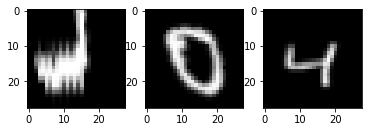

In [195]:
draw_samples(results)

In [196]:
def spatial_transform_input(inputs, transformations):
    grids = generate_normalized_homo_meshgrids(inputs)
    reprojected_grids = transform_grids(transformations, grids,inputs)
    result = bilinear_sample(inputs, reprojected_grids)
    return result

In [197]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout

In [198]:

def create_localization_head(inputs):
#     x = Conv2D(32, (3,3),padding='valid',activation="relu")(inputs)
    #x = Flatten()(inputs)
    #x = Dense(128, activation='relu')(x)
    #x = Dense(60, activation='relu')(x)  
    #x = MaxPooling2D((2, 2))(inputs)
    x = Conv2D(14, (5,5),padding='valid',activation="relu")(inputs)
    x = MaxPooling2D((2, 2), strides=2)(x)
    x = Conv2D(32, (5,5), padding='valid',activation="relu")(x)
    x = MaxPooling2D((2, 2),strides=2)(x)
    #x = Conv2D(120, (5,5), padding='valid',activation="relu")(x)
    x = Flatten()(x)    
    x = Dense(120, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(84, activation='relu')(x)
    #x = Dropout(0.2)(x)
    x = Dense(6, activation="linear", kernel_initializer="zeros",
              bias_initializer=lambda shape, dtype: tf.constant([1,0,0,0,1,0], dtype=dtype))(x) # 6 elements to describe the transformation
    
    return tf.keras.Model(inputs, x)

In [224]:
def run_model(inputs):
    x = Conv2D(6, (3,3),padding='valid',activation="relu")(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(16, (3,3),padding='valid',activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(120, activation='relu')(x)
    x = Dense(84, activation='relu')(x)
    x = Dense(10)(x)
    return x

    
model_baseline = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [225]:
inputs = Input(shape=(H,W,1))
localization_head= create_localization_head(inputs)
x = spatial_transform_input(inputs, localization_head.output)
x = run_model(x)
#x = model_baseline(x)
st= tf.keras.Model(inputs, x)


In [226]:
localization_head(inputs)

<KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'model_8')>

In [227]:
st.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 24, 24, 14)   364         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 12, 12, 14)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 8, 8, 32)     11232       max_pooling2d_18[0][0]           
____________________________________________________________________________________________

In [228]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
st.compile(optimizer="adam",
              loss=loss_fn,
              metrics=['accuracy'])

In [229]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [230]:
st.fit(tf.concat([x_train_aug, x_train],0), tf.concat([y_train, y_train],0), epochs=5,callbacks=[tensorboard_callback])
#st.fit(x_train_aug, y_train, epochs=5,callbacks=[tensorboard_callback])

#st.fit( x_train,y_train, epochs=5,callbacks=[tensorboard_callback])

Epoch 1/5
3750/3750 [==============================] - 56s 15ms/step - loss: 0.5007 - accuracy: 0.8447
Epoch 2/5
3750/3750 [==============================] - 58s 16ms/step - loss: 0.1031 - accuracy: 0.9679
Epoch 3/5
3750/3750 [==============================] - 58s 16ms/step - loss: 0.0836 - accuracy: 0.9746
Epoch 4/5
3750/3750 [==============================] - 58s 16ms/step - loss: 0.0745 - accuracy: 0.9771
Epoch 5/5
3750/3750 [==============================] - 58s 16ms/step - loss: 0.0656 - accuracy: 0.9794


In [85]:
st.save("./spatial_transformer_model")
st.save_weights('./patial_transformer_weights')

INFO:tensorflow:Assets written to: ./spatial_transformer_model/assets


In [86]:
#%tensorboard --logdir logs

In [231]:
st.evaluate(x_test_aug, y_test)

313/313 [==============================] - 3s 7ms/step - loss: 0.1141 - accuracy: 0.9646


[0.11407934874296188, 0.9646000266075134]

In [232]:
st.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0362 - accuracy: 0.9889


[0.03620568662881851, 0.9889000058174133]

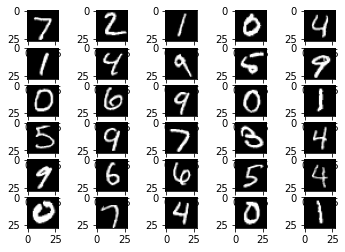

In [233]:
draw_samples(x_test[:30])

In [234]:
test_data = x_test_aug[:30]
label = y_test[:30]

In [235]:
logits = st.predict(test_data)
print("prediction: ", tf.math.argmax(logits, axis=-1).numpy())
print("label:      ", label)


prediction:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 8 4 9 6 6 5 4 0 7 4 0 1]
label:       [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


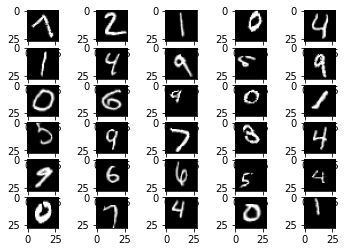

In [236]:
draw_samples(test_data)

In [237]:
predicted_transforms = localization_head.predict(test_data)


In [238]:
#predicted_transforms

In [239]:
transformed_inputs = spatial_transform_input(test_data, predicted_transforms)

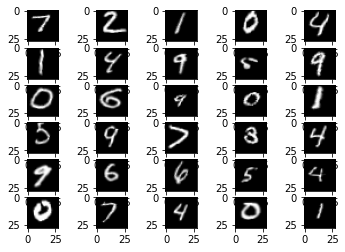

In [240]:
draw_samples(transformed_inputs)

In [115]:
!curl "https://raw.githubusercontent.com/daviddao/spatial-transformer-tensorflow/master/data/mnist_sequence1_sample_5distortions5x5.npz" --output cluttered_mnist/mnist_sequence1_sample_5distortions5x5.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3751k  100 3751k    0     0  2385k      0  0:00:01  0:00:01 --:--:-- 2383k


(10000, 28, 28, 1)


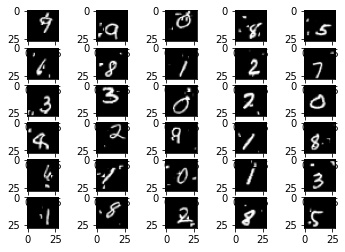

In [116]:
with np.load('cluttered_mnist/mnist_sequence1_sample_5distortions5x5.npz') as cluttered_mnist:
    X_train = cluttered_mnist['X_train'].reshape(-1,40,40,1)
    Y_train = cluttered_mnist['y_train']
    X_test = cluttered_mnist['X_test'].reshape(-1,40,40,1)
    Y_test = cluttered_mnist['y_test']
    X_train = tf.image.resize(X_train, (28,28))
    X_test = tf.image.resize(X_test, (28,28))
    print(X_train.shape)
    draw_samples(X_train[:30])

In [117]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [118]:
model.fit(X_train, Y_train, epochs=6)
model.evaluate(X_test, Y_test)

Epoch 1/6
313/313 [==============================] - 1s 4ms/step - loss: 0.5014 - accuracy: 0.8421
Epoch 2/6
313/313 [==============================] - 1s 4ms/step - loss: 0.2274 - accuracy: 0.9266
Epoch 3/6
313/313 [==============================] - 1s 4ms/step - loss: 0.1574 - accuracy: 0.9516
Epoch 4/6
313/313 [==============================] - 1s 4ms/step - loss: 0.1054 - accuracy: 0.9698
Epoch 5/6
313/313 [==============================] - 1s 4ms/step - loss: 0.0735 - accuracy: 0.9813
Epoch 6/6
32/32 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.9330


[0.21055179834365845, 0.9330000281333923]

In [119]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.2106 - accuracy: 0.9330


[0.21055179834365845, 0.9330000281333923]

In [120]:
st.fit(X_train,Y_train, epochs=6)


Epoch 1/6
313/313 [==============================] - 5s 15ms/step - loss: 0.2248 - accuracy: 0.9307
Epoch 2/6
313/313 [==============================] - 5s 15ms/step - loss: 0.1249 - accuracy: 0.9582
Epoch 3/6
313/313 [==============================] - 5s 15ms/step - loss: 0.0998 - accuracy: 0.9674
Epoch 4/6
313/313 [==============================] - 5s 15ms/step - loss: 0.0859 - accuracy: 0.9708
Epoch 5/6
313/313 [==============================] - 5s 15ms/step - loss: 0.0711 - accuracy: 0.9760
Epoch 6/6
313/313 [==============================] - 5s 15ms/step - loss: 0.0588 - accuracy: 0.9795


In [121]:
st.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 8ms/step - loss: 0.0885 - accuracy: 0.9710


[0.08853834867477417, 0.9710000157356262]

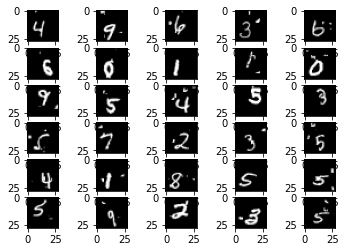

In [122]:
Test_data = X_test[:30]
draw_samples(Test_data)

In [123]:
predicted_transforms = localization_head.predict(Test_data)

In [124]:
transformed_inputs = spatial_transform_input(Test_data, predicted_transforms)

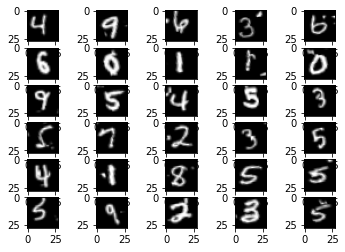

In [125]:
draw_samples(transformed_inputs)